In [1]:
from model_runner import ModelRunner
from DBPN import DBPN
from SRCNN_different_specs import RunSRCNN, SRCNN
from custom_image_dataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
from torch import nn
from image_helper import ImageHelper

/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_ROOT="./datasets/"
DATASET_NAME = "Set5"

In [3]:
%%time
transform_x = transforms.Compose([
    transforms.Resize((8, 8), interpolation=Image.BICUBIC),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((32, 32))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_train", transform=transform_x, target_transform=transform_y)
validation_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_validation", transform=transform_x, target_transform=transform_y)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
100%|██████████| 5/5 [00:00<00:00, 486.10it/s]

Training set has 163 instances
Validation set has 68 instances
CPU times: user 68.1 ms, sys: 26.5 ms, total: 94.6 ms
Wall time: 113 ms


In [4]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(0.35*(2**13))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory) # TODO: aumentar batch_size p/ 2^12
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: user 1.82 ms, sys: 2.59 ms, total: 4.42 ms
Wall time: 3.45 ms


In [5]:
# The learning rate is initialized to 1e − 4 for all layers and decrease by a factor of 10 for every 5 × 105 iterations for total 106 iterations.
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DBPN().to(device)
model_runner = ModelRunner()

# For optimization, we use Adam with momentum to 0.9 and weight decay to 1e−4.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=0.01,
    total_iters=60)

In [6]:
# %%time
# model_runner.train(
#     model=model,
#     train_dataloader=train_dataloader,
#     validation_dataloader=validation_dataloader,
#     optimizer=optimizer,
#     epochs=7,
#     scheduler=scheduler,
#     loss_fn=nn.MSELoss(),
# )

In [7]:
a = torch.randn(2, 2, 3)
a = torch.unsqueeze(a, 0)
a.shape

torch.Size([1, 2, 2, 3])

In [8]:
# input = torch.randn(1, 3, 256, 256)
input = torch.randn([1, 3, 8, 8])
output = model(input)
print(output.shape)

torch.Size([1, 3, 32, 32])


[apply_model_to_image] image.size = (33, 33)
[apply_model_to_image] tensor.shape = torch.Size([1, 3, 8, 8])
[apply_model_to_image_and_show] tensor.shape = torch.Size([1, 3, 32, 32])
[show_tensor_as_image] tensor_np.shape = (1, 3, 32, 32)


TypeError: Invalid shape (3, 32, 32) for image data

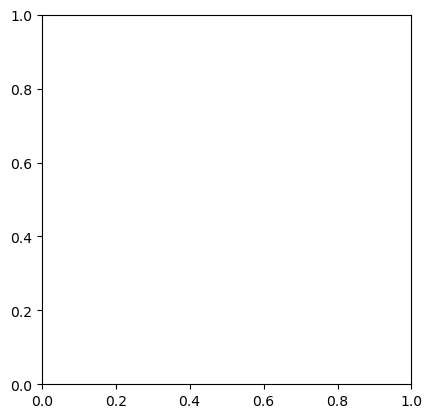

In [9]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=model,
    image=f"datasets/Set5_train/patches/baby_patch/patch_0.png",
    downsample_factor=4
)